In [1]:
import warnings
warnings.simplefilter("ignore")

import re
import os
import pexpect
import numpy as np
import pandas as pd
import networkx as nx
import starwrap as sw
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from enum import Enum
from sklearn.manifold import TSNE
from scipy.spatial import distance

In [9]:
class Mode(Enum):
    PREDICT = 1
    EMBEDDING = 2
    SIMILAR_N = 3

class StarSpaceInterface(object): 
    
    def __init__(self, mode, **kwarg):
        self.mode = mode
        if self.mode == Mode.PREDICT:
            cmd = '{} {} {} {}'.format(kwarg["starspace_path"] + "query_predict", kwarg["model_path"], kwarg["k"] if "k" in kwarg else 1, kwarg["baseDocs"] if "baseDocs" in kwarg else "")
            self.child = pexpect.spawn(cmd)
            self.child.expect('Enter some text: ', timeout=120)
        elif self.mode == Mode.EMBEDDING:
            cmd = '{} {}'.format(kwarg["starspace_path"] + 'embed_doc', kwarg["model_path"])
            self.child = pexpect.spawn(cmd)
            self.child.expect('Input your sentence / document now:', timeout=120)
        elif self.mode == Mode.SIMILAR_N:
            cmd = '{} {} {}'.format(kwarg["starspace_path"] + 'query_nn', kwarg["model_path"], kwarg["k"] if "k" in kwarg else 5)
            self.child = pexpect.spawn(cmd)
            self.child.expect('Enter some text: ', timeout=120)
            
    def predict(self, text):
        if self.mode == Mode.PREDICT:
            self.child.sendline(text)
            self.child.expect('Enter some text: ')
            stdout = self.child.before.decode('utf-8')
            lines = stdout.split('\n')
            results = []
            for line in lines:
                search = re.search(r'(\d)\[(\d+\.\d+)\]:\s(.*)\s+', line)
                if search:
                    label = search.group(3).strip()
                    proba = float(search.group(2).strip())
                    results.append(dict(label=label, proba=proba))
            return results
        
        elif self.mode == Mode.EMBEDDING:
            self.child.sendline(text)
            self.child.expect(text + r"\r\n")
            self.child.expect(text + r"\r\n")
            self.child.expect(r" \r\n")
            return [dict(word=text.strip(), embedding=self.child.before.decode("utf-8").split(" "))]
        
        elif self.mode == Mode.SIMILAR_N:
            self.child.sendline(text)
            self.child.expect('Enter some text: ')
            lines = self.child.before.decode("utf-8").split('\n')
            results = []
            for line in lines[1:-1]:
                line = line.split(" ")
                results.append(dict(word=line[0].strip(), proba=float(line[1].strip())))
            return results

In [5]:
arg = sw.args()

In [6]:
arg.trainFile = '../../../sspace/data/oms/oms-rel_joint.txt'
arg.trainMode = 4
arg.similarity='cosine'
arg.verbose = True
arg.initRandSd = 0.01
arg.ngrams = 1
arg.lr = 0.01
arg.epoch = 10
arg.thread = 10
arg.dim = 300
arg.margin = 0.05
arg.batchSize = 5
arg.negSearchLimit = 5
arg.maxNegSamples = 10
arg.shareEmb = False
arg.label = "__label__"
arg.dropoutRHS = 0.2

sp = sw.starSpace(arg)
sp.init()
sp.train()

sp.saveModel('../../../sspace/model/oms/oms-d300-init-h-doc')
sp.saveModelTsv('../../../sspace/model/oms/oms-d300-init-h-doc.tsv')

# sp.initFromSavedModel('../../../sspace/model/oms/oms-d300-init-h')
# sp.initFromTsv('../../../sspace/model/oms/oms-d300-init-h.tsv')

In [10]:
interface = StarSpaceInterface(Mode.SIMILAR_N, starspace_path="../../../StarSpace/", model_path="../../../sspace/model/oms/oms-d300-init-h-doc")

In [11]:
labels = pd.read_csv("../../../sspace/model/oms/oms-d300-init-h.tsv", sep="\t", encoding="utf-8", header=None, index_col=0)

In [12]:
store = interface.predict("__label__cell-biology")

In [13]:
for k in store:
    emb_p = np.array(labels.loc[[k['word']]]).squeeze()
    print(k)

{'word': '__label__cell-biology', 'proba': 1.0}
{'word': '__label__immunology', 'proba': 0.510408}
{'word': '__label__systems-biology', 'proba': 0.473934}
{'word': '__label__biotechnology', 'proba': 0.472964}
{'word': '__label__endocrinology', 'proba': 0.4726}


In [14]:
graph = nx.read_edgelist("../../../sspace/data/oms/cat_hier_inplace.txt", nodetype=str, create_using=nx.DiGraph)

In [15]:
keys = ["__label__bioengineering", "__label__earth-history", "__label__civics", "__label__cell-biology", "__label__historiography"]

In [16]:
embedding_clusters, word_clusters = [], []

for word in keys:
    embeddings = []
    words = []
    for pred in interface.predict(word):
        if pred["word"] not in words:
            words.append(pred["word"])
            emb_p = np.array(labels.loc[[pred["word"]]]).squeeze()
            embeddings.append(emb_p)
    
    for parent in graph.successors(word):
        words.append(parent)
        emb_t = np.array(labels.loc[[parent]]).squeeze()
        embeddings.append(emb_t)
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [17]:
embedding_clusters = np.array(embedding_clusters)

In [18]:
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [19]:
embeddings_en_2d.shape

(5, 6, 2)

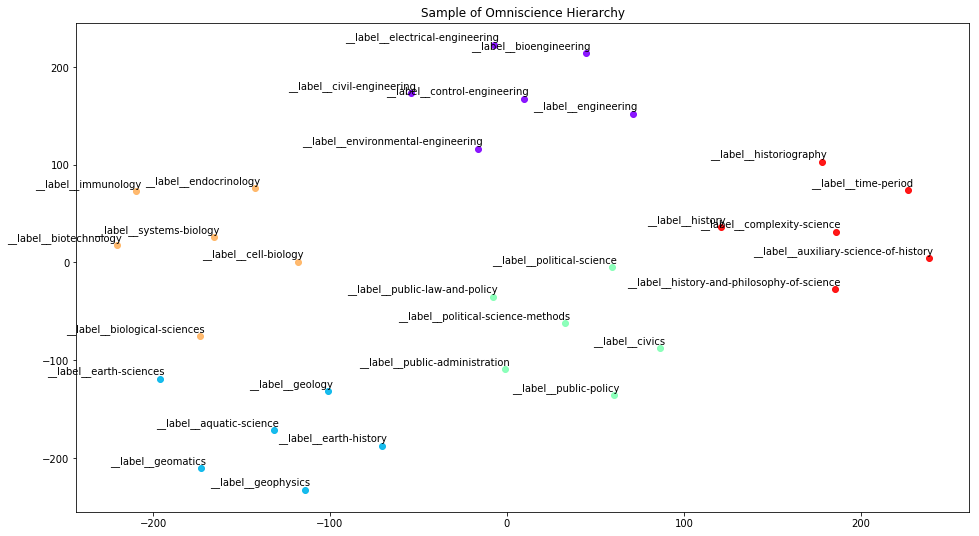

In [20]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.plot(x, y, c=color, alpha=a, label=label, marker='o', linestyle='None')
        for i, word in enumerate(words):
            plt.annotate(word, alpha=1, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
#     plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Sample of Omniscience Hierarchy', keys, embeddings_en_2d, word_clusters, 0.9, 'oms_hier_text.png')